In [3]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sklearn

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


import eli5
# import lime
# import lime.lime_tabular
# import shap

#yh edits
import math

In [4]:
df1_output = pd.read_csv("df1_output.csv")

In [5]:
from sklearn.model_selection import train_test_split, KFold
xtrain, xtest, ytrain, ytest = train_test_split(df1_output.drop(columns=['price']), pd.DataFrame(df1_output['price']), test_size=0.2, random_state=22)

In [6]:
ytrain = ytrain.price.ravel()
ytest = ytest.price.ravel()


In [7]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
random_forest = RandomForestRegressor(random_state=22)
 

In [67]:
# https://scikit-learn.org/stable/modules/cross_validation.html

# test for 2 Ks
k1 = 5
k2 = 10
random_forest = RandomForestRegressor(random_state=22)
random_forest.fit(xtrain, ytrain)
kfolds = KFold(k1, random_state =22).get_n_splits(xtrain) # split based on xtrain
cross_val_score(random_forest,xtrain, ytrain, scoring = 'neg_mean_squared_error',cv = kfolds)


C:\Users\Yi_Ha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Yi_Ha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Yi_Ha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Yi_Ha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Yi_Ha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

array([-0.23727444, -0.23124851, -0.2291651 , -0.24107104, -0.22704174])

It seems that the model is doing well against new data

# Feature Importance

Before any hyperparamter tuning

Feature ranking:


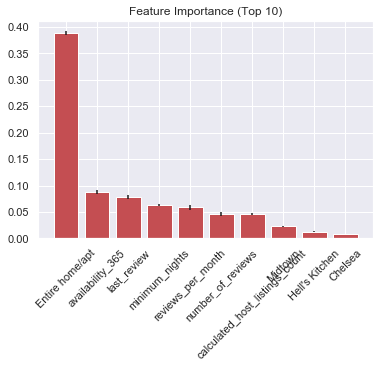

In [72]:
impt_feat = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)
indices = np.argsort(impt_feat)[::-1]
indices = indices[:10] # show top 20
print("Feature ranking:")

# counter = 0
# for n in range(xtrain.shape[1]):
#     print("%d. feature %d (%f)" % (n + 1, indices[n], impt_feat[indices[n]]))
#     counter+=1
#     if counter == 20: break
        
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature Importance (Top 10)")
plt.bar(range(10), impt_feat[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(10), xtrain.columns[indices], rotation = 45)
# plt.xlim([-1, xtrain.shape[1]])
plt.show()

# Decision Tree

In [48]:
from sklearn.tree import DecisionTreeRegressor

decision_tree = DecisionTreeRegressor(max_depth = 5)
decision_tree.fit(xtrain,ytrain)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [49]:
decision_tree_deep = DecisionTreeRegressor()
decision_tree_deep.fit(xtrain,ytrain)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [50]:
cross_val_score(decision_tree,xtrain,ytrain).mean()

C:\Users\Yi_Ha\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.43934710382987613

In [51]:
cross_val_score(decision_tree_deep, xtrain,ytrain).mean()

C:\Users\Yi_Ha\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.2190234139866095

In [52]:
deep_predict = decision_tree_deep.predict(xtest)
normal_predict = decision_tree.predict(xtest)

print(mean_squared_error(ytest, deep_predict))
print(mean_squared_error(ytest, normal_predict))

0.3573968571267495
0.26213037337565653


Deep decision tree overfitted on training set

import os
os.environ['PATH'].split(os.pathsep)
os.environ['PATH'] += os.pathsep + 'C:\\Users\\Zhe Hao\\Anaconda3\\Library\\bin\\graphviz'

import graphviz 
from graphviz import Source
import time

def save_tree_img(model):
    dot_data = sklearn.tree.export_graphviz(model, out_file=None)
    #print(dot_data)
    graph = graphviz.Source(dot_data) 
    seconds = time.time()
    graph.render(str(seconds) + "model",view = True)

## Random Forest

### Hyperparamter Tuning

#### Methodology:
1) Attempt Random Search to find best hyper parameters <br/>
2) Continue with Grid Search with Cross Validation

In [1]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 22)

In [18]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [44]:
rf_random.best_params_

{'n_estimators': 160,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 0.1,
 'max_depth': None,
 'bootstrap': True}

In [19]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=22)
# Fit the random search model
rf_random.fit(xtrain,ytrain)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] n_estimators=140, min_samples_split=2, min_samples_leaf=4, max_features=0.5, max_depth=20, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=140, min_samples_split=2, min_samples_leaf=4, max_features=0.5, max_depth=20, bootstrap=False, total=  49.0s
[CV] n_estimators=140, min_samples_split=2, min_samples_leaf=4, max_features=0.5, max_depth=20, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.9s remaining:    0.0s


[CV]  n_estimators=140, min_samples_split=2, min_samples_leaf=4, max_features=0.5, max_depth=20, bootstrap=False, total=  47.2s
[CV] n_estimators=140, min_samples_split=2, min_samples_leaf=4, max_features=0.5, max_depth=20, bootstrap=False 
[CV]  n_estimators=140, min_samples_split=2, min_samples_leaf=4, max_features=0.5, max_depth=20, bootstrap=False, total=  44.8s
[CV] n_estimators=180, min_samples_split=10, min_samples_leaf=4, max_features=0.5, max_depth=70, bootstrap=False 
[CV]  n_estimators=180, min_samples_split=10, min_samples_leaf=4, max_features=0.5, max_depth=70, bootstrap=False, total= 1.4min
[CV] n_estimators=180, min_samples_split=10, min_samples_leaf=4, max_features=0.5, max_depth=70, bootstrap=False 
[CV]  n_estimators=180, min_samples_split=10, min_samples_leaf=4, max_features=0.5, max_depth=70, bootstrap=False, total= 1.6min
[CV] n_estimators=180, min_samples_split=10, min_samples_leaf=4, max_features=0.5, max_depth=70, bootstrap=False 
[CV]  n_estimators=180, min_sam

[CV]  n_estimators=120, min_samples_split=5, min_samples_leaf=1, max_features=0.4, max_depth=70, bootstrap=True, total=  33.7s
[CV] n_estimators=120, min_samples_split=5, min_samples_leaf=1, max_features=0.4, max_depth=70, bootstrap=True 
[CV]  n_estimators=120, min_samples_split=5, min_samples_leaf=1, max_features=0.4, max_depth=70, bootstrap=True, total=  35.2s
[CV] n_estimators=120, min_samples_split=5, min_samples_leaf=1, max_features=0.4, max_depth=70, bootstrap=True 
[CV]  n_estimators=120, min_samples_split=5, min_samples_leaf=1, max_features=0.4, max_depth=70, bootstrap=True, total=  34.1s
[CV] n_estimators=140, min_samples_split=2, min_samples_leaf=4, max_features=0.5, max_depth=40, bootstrap=False 
[CV]  n_estimators=140, min_samples_split=2, min_samples_leaf=4, max_features=0.5, max_depth=40, bootstrap=False, total= 1.0min
[CV] n_estimators=140, min_samples_split=2, min_samples_leaf=4, max_features=0.5, max_depth=40, bootstrap=False 
[CV]  n_estimators=140, min_samples_split

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 39.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [21]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    print('Model Performance')
    print('Average Error: {:0.4f} '.format(np.mean(errors)))
    
    return errors

base_model = RandomForestRegressor(n_estimators = 10, random_state =22)
base_model.fit(xtrain,ytrain)
base_accuracy = evaluate(base_model, xtest, ytest)
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, xtest, ytest)

Model Performance
Average Error: 0.3394 degrees.
Model Performance
Average Error: 0.3142 degrees.


In [45]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10,30,50,None],
    'max_features': [0.1,0.2],
    'min_samples_leaf': [1],
    'min_samples_split': [2,3,4],
    'n_estimators': [40,80,120,160]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, verbose = 2)

grid_search.fit(xtrain,ytrain)
grid_search.best_params_


best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, xtest, ytest)

Here we identify that the best model is created with RandomizedSearchCV, producing a model with error of 0.3142. 